In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
#Quantum Monte Carlo - Diffusion

class dmc:
    
    def __init__(self, num_walkers_start=1000, target_walkers=1000, walkers_start_position =0.0, num_steps = 1000, step = 0.1, e_r= 0.,
                 burn_in = 300, num_bins = 200, x_min = -20, x_max = 20):
        #Initialization
        self.num_walkers_start =  num_walkers_start
        self.walkers_start_position = walkers_start_position
        self.target_walkers = target_walkers
        self.num_steps = num_steps
        self.step = step
        self.e_r = e_r
        self.burn_in = burn_in
        self.num_bins = num_bins
        self.x_min = x_min
        self.x_max = x_max
        
        self.walkers = np.full(num_walkers_start, walkers_start_position)
        

    def potential_harmonic(self):
        """Computes the potential values at given locations x for a simple harmonic oscillator
        Input:  m     :: the mass of the walkers
                omega :: the angular frequency of the walkers
        """      
        v = 0.5*self.walkers*2
        return v

    def potential_morse(x):
        """Computes the potential values at given locations x for a simple harmonic oscillator
        Input:  m     :: the mass of the walkers
                omega :: the angular frequency of the walkers
                a     :: defining parameter - will be set to 1 for ease of solution
        """
        v = 0.5*(np.exp( -2*a*x ) - 2*np.exp( -a*x ) )
        return v

    def run_dmc(self):
        """Simulates a quantum system using the quantum diffusion method"""
        wave_function = np.zeros(self.num_bins)
        e_0 = []
        
        print(self.walkers.size)
        for i in range(self.num_steps):
            #Perform a random walk
            for j in range(self.walkers.size):
                self.walkers[j] += np.random.normal() * self.step
            num_walkers_old = self.walkers.size
            
            #Determine the weight function
            energy = np.zeros_like(self.walkers)                                       #finding the weight for each walker
            energy = 1. -(self.potential_harmonic() - self.e_r) * self.step**2
            weight = np.int_(energy)                                              #convert to int per the algorithm
            new_walkers = np.zeros_like(self.walkers)                                  #how many new walkers each walker spawns
            new_walkers = np.minimum(3, weight + np.random.random())

            #Make a new array of walkers
            keep = np.compress(new_walkers > 0, self.walkers)        #get an array of each walker still existing
            duplicate1 = np.compress(new_walkers > 1, self.walkers)  #get an array of each walker duplicated
            duplicate2 = np.compress(new_walkers > 2, self.walkers)  #get an array of each walker twice duplicated
            self.walkers = np.append(keep, duplicate1)                  #combine the above arrays into a complete array of walkers
            self.walkers = np.append(self.walkers, duplicate2)
            
            #Once burn-in is complete, add values to the histogram
            if i>self.burn_in:
                hist, bin_edges = np.histogram(self.walkers, bins=self.num_bins, range=(self.x_min, self.x_max))
                wave_function += hist                                             #add the walker distribution at this step to the total distribution
                e_0.append(np.mean(self.potential_harmonic()))                                       #E_0 estimate at this step

            #Adjust values for next iteration
            self.e_r = np.mean(self.potential_harmonic()) - (self.walkers.size - self.target_walkers) / (self.target_walkers*self.step**2)      #NEED TO CHECK UNITS
            
            print(i, np.mean(self.potential_harmonic()), self.e_r, self.walkers.size)
            
        return wave_function, bin_edges, e_0


1000
0 -0.0240906395393 -48.8240906395 1488
1 -0.0212342503213 -48.8212342503 1488
2 -0.0220630057597 -48.8220630058 1488
3 -0.0236365209513 -48.823636521 1488
4 -0.0197434548112 -48.8197434548 1488
5 -0.0192573552804 -48.8192573553 1488
6 -0.021955200573 -48.8219552006 1488
7 -0.0221877425313 -48.8221877425 1488
8 -0.0169178352953 -48.8169178353 1488
9 -0.0183339204123 -48.8183339204 1488
10 -0.0201502803399 -48.8201502803 1488
11 -0.0239462148981 -48.8239462149 1488
12 -0.0220790281908 -48.8220790282 1488
13 -0.0238078381907 -48.8238078382 1488
14 -0.0225825644191 -48.8225825644 1488
15 -0.0204397965361 -48.8204397965 1488
16 -0.0213233292039 -48.8213233292 1488
17 -0.0257239196298 -48.8257239196 1488
18 -0.0228319576586 -48.8228319577 1488
19 -0.0218700557254 -48.8218700557 1488
20 -0.0238284209221 -48.8238284209 1488
21 -0.0248340760777 -48.8248340761 1488
22 -0.0234818696413 -48.8234818696 1488
23 -0.0233286369387 -48.8233286369 1488
24 -0.0186406865426 -48.8186406865 1488
25 -0.0

238 0.0100691745624 -48.7899308254 1488
239 0.0123933849367 -48.7876066151 1488
240 0.0103489496729 -48.7896510503 1488
241 0.00636969534649 -48.7936303047 1488
242 0.00398713984346 -48.7960128602 1488
243 0.00179264298641 -48.798207357 1488
244 -0.000153369807596 -48.8001533698 1488
245 0.00160473672325 -48.7983952633 1488
246 -0.000439183087602 -48.8004391831 1488
247 0.00459599402523 -48.795404006 1488
248 0.00906595119106 -48.7909340488 1488
249 0.0136612353077 -48.7863387647 1488
250 0.0165569774733 -48.7834430225 1488
251 0.0209924057437 -48.7790075943 1488
252 0.0217172198033 -48.7782827802 1488
253 0.0255205614258 -48.7744794386 1488
254 0.0243147980003 -48.775685202 1488
255 0.0254539133466 -48.7745460867 1488
256 0.0270261376081 -48.7729738624 1488
257 0.0277796748906 -48.7722203251 1488
258 0.0298888814313 -48.7701111186 1488
259 0.0310947936383 -48.7689052064 1488
260 0.0284764340948 -48.7715235659 1488
261 0.0287394299567 -48.77126057 1488
262 0.0274907493647 -48.772509250

445 0.00236452738374 -48.7976354726 1488
446 0.00183716661294 -48.7981628334 1488
447 0.00328850621154 -48.7967114938 1488
448 0.00262175193416 -48.7973782481 1488
449 -0.00153437377306 -48.8015343738 1488
450 -0.0052145933162 -48.8052145933 1488
451 -0.00340947058558 -48.8034094706 1488
452 -0.000509995021847 -48.800509995 1488
453 -0.00088673587997 -48.8008867359 1488
454 -0.00236851416567 -48.8023685142 1488
455 -0.00628789190423 -48.8062878919 1488
456 -0.00571929413907 -48.8057192941 1488
457 -0.0103406543413 -48.8103406543 1488
458 -0.0104357338633 -48.8104357339 1488
459 -0.00851361311974 -48.8085136131 1488
460 -0.00752082329698 -48.8075208233 1488
461 -0.00945753232705 -48.8094575323 1488
462 -0.0102472407202 -48.8102472407 1488
463 -0.0109446985793 -48.8109446986 1488
464 -0.00911927419103 -48.8091192742 1488
465 -0.00960857140859 -48.8096085714 1488
466 -0.0157428623388 -48.8157428623 1488
467 -0.0151395950924 -48.8151395951 1488
468 -0.0170726817195 -48.8170726817 1488
469 

656 -0.0185203071238 -48.8185203071 1488
657 -0.0171133766188 -48.8171133766 1488
658 -0.0184199726871 -48.8184199727 1488
659 -0.0170727653418 -48.8170727653 1488
660 -0.0137604983567 -48.8137604984 1488
661 -0.0118888979606 -48.811888898 1488
662 -0.0123509301191 -48.8123509301 1488
663 -0.0120827467712 -48.8120827468 1488
664 -0.00753571362764 -48.8075357136 1488
665 -0.0131980948123 -48.8131980948 1488
666 -0.0175854338587 -48.8175854339 1488
667 -0.0172733567299 -48.8172733567 1488
668 -0.0126350142135 -48.8126350142 1488
669 -0.00754164629049 -48.8075416463 1488
670 -0.00590785087996 -48.8059078509 1488
671 -0.00864213941388 -48.8086421394 1488
672 -0.00928162941502 -48.8092816294 1488
673 -0.00634909655064 -48.8063490966 1488
674 -0.00758142169657 -48.8075814217 1488
675 -0.00619645084123 -48.8061964508 1488
676 -0.00590076644692 -48.8059007664 1488
677 -0.00329153510404 -48.8032915351 1488
678 -0.00178543430217 -48.8017854343 1488
679 0.00233741190585 -48.7976625881 1488
680 0.

889 -0.00527161075343 -48.8052716108 1488
890 -0.00628487190077 -48.8062848719 1488
891 -0.00680043340031 -48.8068004334 1488
892 -0.00527879734582 -48.8052787973 1488
893 -0.00411801985353 -48.8041180199 1488
894 -0.0017635479406 -48.8017635479 1488
895 0.00115327343093 -48.7988467266 1488
896 0.00169952339054 -48.7983004766 1488
897 0.00487344721044 -48.7951265528 1488
898 0.00490720055064 -48.7950927994 1488
899 0.00427893205218 -48.7957210679 1488
900 0.00418544704172 -48.795814553 1488
901 0.00444099941266 -48.7955590006 1488
902 0.00557068881267 -48.7944293112 1488
903 0.00903021806524 -48.7909697819 1488
904 0.00638973555373 -48.7936102644 1488
905 0.00125148731478 -48.7987485127 1488
906 0.00333362196156 -48.796666378 1488
907 0.000963477512701 -48.7990365225 1488
908 -0.00159848372063 -48.8015984837 1488
909 -0.00135248142027 -48.8013524814 1488
910 0.00125864369657 -48.7987413563 1488
911 0.00281103001179 -48.79718897 1488
912 0.00306511223155 -48.7969348878 1488
913 -0.00231

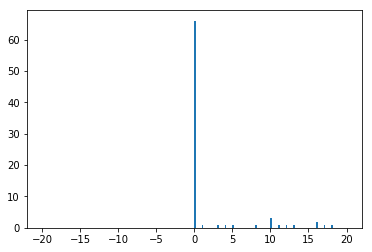

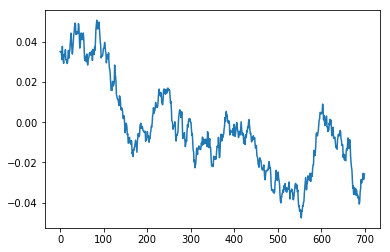

In [45]:
dmc_test_1 = dmc()
wave, bins, e0 = dmc_test_1.run_dmc()
plt.hist(wave, bins=bins)

trial = np.linspace(0, len(e0), len(e0))
plt.figure(2)
plt.plot(trial, e0)

In [93]:
a = np.array([0, 5, 10, 15, 20, 25])
b = np.compress(a>10, a)
print(b)

[15 20 25]
